In [1]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\geogeo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import cv2
from scipy.signal import convolve2d
import numpy as np
import os
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import dctn, idctn
from scipy.io import loadmat
import pandas as pd

In [2]:
from utils.fonctions import lightDirection, lightsDirection, getI

In [3]:
data = loadmat('./data/vase/vase_mat_3.mat')

In [146]:
I = data["I"]
S = data["S"]
masque = data["masque"]
Z = data["Z"]
N = data["N"]

In [211]:
exterieur = masque.flatten() == 0
exterieur= np.reshape(exterieur, masque.shape)

In [199]:
[nb_lignes, nb_colonnes] = masque.shape
[n,p] = I.shape

In [200]:
def stereophotometrie(I,S,masque=None):
    pseudo_inverse_S = np.linalg.pinv(S)
    m = pseudo_inverse_S @ I


    rho_estime = np.sqrt(np.sum(np.square(m), 0))
    N_estime = m / (rho_estime + 1e-3)
    N_estime[:, masque.flatten("F") == 0] = 0

    return rho_estime, N_estime

In [201]:
rho_estime, N_estime = stereophotometrie(I,S,masque)

In [202]:
N_estime[2, exterieur.flatten("F")] = 1

In [212]:
p_estime = np.reshape(-N_estime[0, :] / N_estime[2, :], masque.shape)
p_estime[exterieur] = 0

q_estime = np.reshape(-N_estime[1, :] / N_estime[2, :], masque.shape)
q_estime[exterieur] = 0

In [213]:
p_estime.shape

(256, 256)

In [214]:
def integrationSCS(p, q, gt=None):
    # Compute div(p,q)

    px = 0.5 * (np.roll(p, -1, axis=0) - np.roll(p, 1, axis=0))
    qy = 0.5 * (np.roll(q, -1, axis=1) - np.roll(q, 1, axis=1))

    # Div(p,q) + Boundary Condition
    f = px + qy
    f[0, 1:-1] = 0.5 * (p[0, 1:-1] + p[1, 1:-1])
    f[-1, 1:-1] = 0.5 * (-p[-1, 1:-1] - p[-2, 1:-1])
    f[1:-1, 0] = 0.5 * (q[1:-1, 0] + q[1:-1, 1])
    f[1:-1, -1] = 0.5 * (-q[1:-1, -1] - q[1:-1, -2])

    f[0, 0] = 0.5 * (p[0, 0] + p[1, 0] + q[0, 0] + q[0, 1])
    f[-1, 0] = 0.5 * (-p[-1, 0] - p[-2, 0] + q[-1, 0] + q[-1, 1])
    f[0, -1] = 0.5 * (p[0, -1] + p[1, -1] - q[0, -1] - q[0, -2])
    f[-1, -1] = 0.5 * (-p[-1, -1] - p[-2, -1] - q[-1, -1] - q[-1, -2])

    # Cosine Transform of f
    fsin = dctn(f, norm='ortho')

    # Denominator
    x, y = np.meshgrid(np.arange(p.shape[1]), np.arange(p.shape[0]))
    denom = (2 * np.cos(np.pi * x / p.shape[1]) - 2) + (2 * np.cos(np.pi * y / p.shape[0]) - 2)
    Z = fsin / denom
    Z[0, 0] = 0.5 * (Z[0, 1] + Z[1, 0])  # Or whatever...

    # Inverse Cosine Transform
    U = idctn(Z, norm='ortho')

    if gt is not None:
        moyenne_ecarts = np.mean(U - gt)
        U -= moyenne_ecarts
        npix = p.shape[0] * p.shape[1]
        rmse = np.sqrt(np.sum((U - gt) ** 2) / npix)
        return U, rmse
    else:
        U -= np.min(U)
        return U

In [215]:
z_estime = integrationSCS(q_estime, p_estime)

C:\Users\geogeo\AppData\Local\Temp\ipykernel_10848\2457505807.py:25: RuntimeWarning: divide by zero encountered in divide
  Z = fsin / denom


In [216]:
nb_lignes, nb_colonnes = z_estime.shape
mid_row = np.floor(nb_lignes / 2).astype(int)
mid_col = np.floor(nb_colonnes / 2).astype(int)

# Vérification de la condition et modification du tableau z_estime si nécessaire
if z_estime[mid_row, mid_col] < z_estime[1, 1]:
    z_estime = -z_estime
z_estime[exterieur] = np.NAN

In [217]:
EA = np.degrees(np.arccos(np.sum(N * N_estime, 0)))
EA = np.reshape(EA, masque.shape)
np.mean(EA)

2.8356503998166374

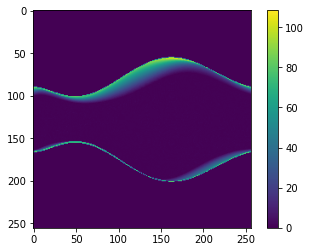

In [218]:
plt.imshow(EA, cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

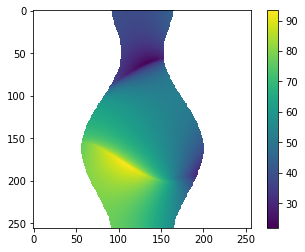

In [219]:
plt.imshow(z_estime, cmap='viridis')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

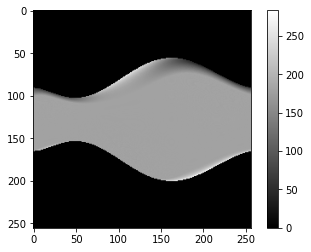

In [193]:
rho_estime = rho_estime.reshape(masque.shape)
plt.imshow(rho_estime, cmap='gray')  # Utilisation de log pour mieux visualiser les différences
plt.colorbar()  # Ajout d'une barre de couleur pour indiquer l'échelle
plt.show()

(256, 256) (256, 256) (256, 256)


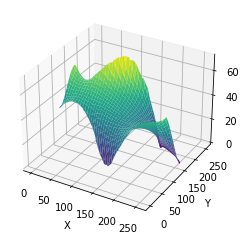

In [194]:
z = z_estime

# Création des coordonnées x et y pour chaque point de la matrice z
x, y = np.meshgrid(np.arange(z.shape[1]), np.arange(z.shape[0]))

print(x.shape, y.shape, z.shape)

# Création de la figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Affichage de la surface 3D
ax.plot_surface(x, y, z, cmap='viridis')

# Étiquetage des axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Hauteur')

# Affichage
plt.show()